In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Perform some Parameter optimization to further improve the performance of the models above
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
#import the wordcloud and matplot
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
%matplotlib inline


# load the json files using pandas

df_fake_train = pd.read_json('fake_train.json')
df_real_train = pd.read_json('real_train.json')
# add additional column to hold the label of the news article
df_fake_train['label'] = 'fake'
df_real_train['label'] = 'real'

# The models will be trained on the concatenation of the news title and text
# Add another column 'news_content' to each dataframe to hold the concatenation of the title and text
df_fake_train['news_content'] = df_fake_train.title+' '+df_fake_train.text
df_real_train['news_content'] = df_real_train.title+' '+df_real_train.text

# load the test json files 
# Repeat all modifications performed on the train dataframes on the test dataframes
df_fake_test = pd.read_json('fake_test.json')
df_fake_test['label'] = 'fake'

df_real_test = pd.read_json('real_test.json')
df_real_test['label'] = 'real'



# Add another column 'news_content' to each dataframe to hold the concatenation of the article title and text
# The models will be trained on the concatenation of the news title and text
df_fake_train['news_content'] = df_fake_train.title+' '+df_fake_train.text
df_real_train['news_content'] = df_real_train.title+' '+df_real_train.text

df_fake_test['news_content'] = df_fake_test.title+' '+df_fake_test.text
df_real_test['news_content'] = df_real_test.title+' '+df_real_test.text


# Check for null or empty news articles  in the training dataframe
print(f"number of fake news articles without titles: {df_fake_train.loc[df_fake_train.title==''].size}")
print(f'number of real news articles without titles: {df_real_train[df_real_train.title==""].size}')
#The number of news articles without title in the fake and real datasets  are 40 and 30 respectively
# The implies that about 95% of the articles have titles

print(f"number of fake news articles without text: {df_fake_train.loc[df_fake_train.text==''].size}")
print(f'number of real news articles without text: {df_real_train[df_real_train.text==""].size}')
# The implies that all the articles have text

number of fake news articles without titles: 40
number of real news articles without titles: 30
number of fake news articles without text: 0
number of real news articles without text: 0


[nltk_data] Downloading package stopwords to /home/jojo89/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Handling the URL
Extract the domain for each url. Later we can try predicting the probability of fakery by looking its the url. The idea is that, it very unlikely  that a website known for publishing fake content will be trusted to publish genuie content.

In [2]:
from urllib3 import get_host
import urllib3
def extractDomain(url):
  return get_host(url)[1]

# Process the URL to get the domain
df_fake_train['src_domain']=df_fake_train.url.apply(extractDomain)
df_real_train['src_domain']=df_real_train.url.apply(extractDomain)

df_fake_test['src_domain']=df_fake_test.url.apply(extractDomain)
df_real_test['src_domain']=df_real_test.url.apply(extractDomain)

print(f'The real news contents are from {len(df_real_train.src_domain.unique())} main sources which are: {df_real_train.src_domain.unique()}')
print(f'The fake news contents are from {len(df_fake_train.src_domain.unique())} main sources which include: {df_fake_train.src_domain.unique()[:10]}')

The real news contents are from 16 main sources which are: ['www.thetimes.co.uk' 'www.bbc.com' 'www.theguardian.com' 'yle.fi'
 'news.err.ee' 'www.themoscowtimes.com' 'www.economist.com' 'apnews.com'
 'www.axios.com' 'www.nytimes.com' 'www.dw.com' 'www.euronews.com'
 'www.theatlantic.com' 'www.reuters.com' 'www.wsj.com' 'time.com']
The fake news contents are from 404 main sources which include: ['nabd.com' 'shamra.sy' 'sudanewsnow.com' 'arabic.rt.com' 'www.kachaf.com'
 'www.almayadeen.net' 'az.sputniknews.ru' 'headtopics.com'
 'akhbarelyom.com' 'www.albidda.net']


As shown above the real news contents are from reputable and well knowns news agencies. In contrast, the some of urls for the fake news looks very suspicious from just looking at them.

In [3]:
# Combine the dataframes
df_all_articles = pd.concat([df_fake_train,df_real_train],axis=0,ignore_index=True)
df_all_articles_test = pd.concat([df_fake_test,df_real_test],axis=0,ignore_index=True)

# Let shuffle the new dataframe a see some examples
from sklearn.utils import shuffle
df_all_articles=shuffle(df_all_articles)
df_all_articles.reset_index(drop=True,inplace=True)

df_all_articles_test =shuffle(df_all_articles_test)
df_all_articles_test.reset_index(drop=True,inplace=True)
df_all_articles.tail(5)

,url,title,text,label,news_content,src_domain
1595,https://time.com/5791472/cruise-ship-sailing-f...,Cruise Ship Sailing for Mexico After Being Den...,A ship operated by MSC Cruises is sailing for ...,real,Cruise Ship Sailing for Mexico After Being Den...,time.com
1596,https://az.sputniknews.ru/expert/20200316/4234...,"Fascinated by attacks on Russia, Europe forgot...","Alexandra Zueva, Sputnik Azerbaijan\nThe ban o...",fake,"Fascinated by attacks on Russia, Europe forgot...",az.sputniknews.ru
1597,https://www.economist.com/finance-and-economic...,Free exchange - Should the IMF dole out more s...,GOVERNMENTS AROUND the world are seeing their ...,real,Free exchange - Should the IMF dole out more s...,www.economist.com
1598,https://www.reuters.com/article/us-health-coro...,Tom Hanks sends typewriter to bullied Australi...,MELBOURNE (Reuters) - Tom Hanks has sent a let...,real,Tom Hanks sends typewriter to bullied Australi...,www.reuters.com
1599,https://www.aljarida.com.tn/articles/%D8%B7%D8...,A famous Russian doctor reveals the secret of ...,"April 04, 2020 - 14:27 min\nElena Malysheva, t...",fake,A famous Russian doctor reveals the secret of ...,www.aljarida.com.tn


In [4]:
# Compute the number of news articles for each src_domain
srcDomains= df_all_articles.groupby(by=['src_domain','label'],as_index=False).count().reset_index()
srcDomains.head(30)

,index,src_domain,label,url,title,text,news_content
0,0,24.ae,fake,1,1,1,1
1,1,24.com.eg,fake,1,1,1,1
2,2,360tv.ru,fake,1,1,1,1
3,3,46-105-42-7.ovh.net,fake,1,1,1,1
4,4,6060news.com,fake,1,1,1,1
5,5,abcnews.com.ge,fake,1,1,1,1
6,6,abundanthope.net,fake,1,1,1,1
7,7,actualidad.rt.com,fake,1,1,1,1
8,8,afaq.tv,fake,1,1,1,1
9,9,againsterhab.com,fake,1,1,1,1


In [5]:
# Lets check the null accuracy
def get_null_accuracy(y_test):
  counts = pd.value_counts(y_test)
  null_accuracy= max(counts)/float(len(y_test))
  print(f'The null Accuracy is: {null_accuracy}')
  return null_accuracy

  # Let have a sneak-peak through the test-set to know the performance of the model always classifying each news article as real
null_accuracy=get_null_accuracy(df_all_articles_test.label)

The null Accuracy is: 0.5


**Create a wordcloud to see some of the most frequent words employed by the news creators**

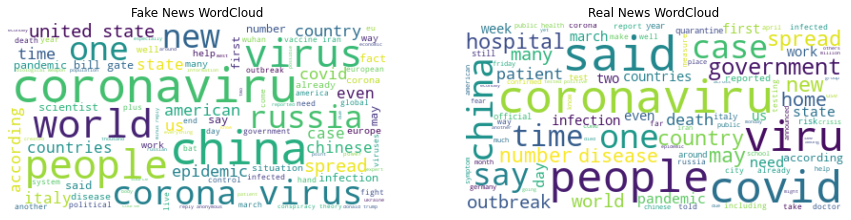

In [6]:
# Before training any model let's see some of the most frequent words used to write each article type
# Add some words with less information to the stopwords
# 
stopword_list = set(STOPWORDS)
stopword_list.update(stopwords.words('english'))
stopword_list.update(['said,already,say,said'])

# Generate the wordcloud for the fake and real news articles
wordcloud = WordCloud(stopwords=stopword_list,max_font_size=50,max_words=100,
                      background_color='white').generate(' '.join([f for f in df_fake_train.news_content]).lower())
fig,(ax1,ax2) = plt.subplots(1,2)
fig.set_figwidth(15)
ax1.imshow(wordcloud,interpolation='bilinear')
ax1.axis("off")
ax1.set_title('Fake News WordCloud')

#Plot the wordcloud for the content of the real news
wordcloud_real = WordCloud(stopwords=stopword_list,
                      max_font_size=50,max_words=100,
                      background_color='white').generate(' '.join([f for f in df_real_train.news_content]).lower())
ax2.imshow(wordcloud_real,interpolation='bilinear')
ax2.axis("off")
ax2.set_title('Real News WordCloud')
# save the wordclouds
plt.savefig('wordclouds.png')
plt.show()


## ***Observation:***
The above wordclouds show most frequent words/phrases used among the fake and real news articles. Across the different groups, it appears most of the articles are talking about the current corona virus pandemis. Interestingly unlike the real news, the wordcloud for the fake news strongly highlights countries (such as China, Russia and United State) usually mentioned by conspiracy theorists . From the real news wordcloud, one can clearly
WordCloud for the real news contains a well balance of common words used to report news happening around the world.

# Create the Prediction models

In [7]:
# We have news items such as title, domain and text which can be employed to make the prediction
# Positive classification is predicting 'real'
# Negative classification is predicting 'fake'
# Model selection consideration:
  # A good model will have lower False positive i.e Fake articles classified as real news
  # A good model will have higher True negative

# Questions answers
# Can we classify a news article as fake or real by looking at variables such as only the title, only the text or possibly the URL?
# Case 1: 
  #The title of an article can be considered the summary of the article
  #therefore, Can we predict the probability of news being  fake from only the title? or What is performance of the 
  # model making predictions based on the title of the articles
# Case 2:
  # Can we predict using only the text?
# Case 3: BaseModel
  # make prediction using text and title?
# 4 Models to try: logistic Regression, PassiveAggressive Classifier, RandomForrest, MultinormalNB

In [8]:
# load the libraries needed
# We will use the TfidfVectorizer and CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer,CountVectorizer
# Build the classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import PassiveAggressiveClassifier,LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,confusion_matrix

# For Sentence Preprocessing and the other modules needed
from utils.helpers import *
from sklearn.preprocessing import LabelEncoder
#  Extract and encoder the labels
labelEncoder= LabelEncoder()
y_train = df_all_articles.label
y_test = df_all_articles_test.label
y_train = labelEncoder.fit_transform(y_train)
y_test=  labelEncoder.transform(y_test)


dataprep = BasicPreprocessor()

[nltk_data] Downloading package stopwords to /home/jojo89/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Case 1**
 The title sentence can be regarded as the summary of the article.
 
 Question: Can the authenticity of an article be verified by looking at just the title?

In [9]:
# Classification Based on the Article Title
# We will use the TFIDF for all the classifier Except the MultinormalNB

# Generate the Vectorizers for only the title content
X_train_title= dataprep(df_all_articles.title.values)
X_test_title = dataprep(df_all_articles_test.title.values)

# Build and fit the TFIDF Vectorizer
title_document_vectorizer = TfidfVectorizer(max_df=0.5, 
                                            ngram_range=(1,4),
                                            use_idf=True,
                                            stop_words= nltk.corpus.stopwords.words('english'))

# Build and fit the BOW Vectorizer
title_bow_vectorizer = CountVectorizer(stop_words= nltk.corpus.stopwords.words('english'))

X_train_title= df_all_articles.title.values
X_test_title = df_all_articles_test.title.values

In [56]:
#title_bow_vectorizer.get_feature_names()

In [11]:
# Train The PassiveAggressive Classifier
# Model 1: PassiveAggressiveClassifier
title_pa_pipe_classifier,title_pa_y_pred,title_pa_cmatrix,title_pa_cm = fitEvalModel(X_train_title,
                                              y_train,title_document_vectorizer,
                                              PassiveAggressiveClassifier(),
                                              BasicPreprocessor(),
                                              'PassiveAggressive', X_test_title,
                                              y_test,labelEncoder,plot_cm=False)

# Model 2: LogisticClassifier
title_lg_pipe_classifier,title_lg_y_pred,title_lg_cmatrix,title_lg_cm = fitEvalModel(X_train_title,
                                              y_train,title_document_vectorizer,
                                              LogisticRegression(max_iter=200,),
                                              BasicPreprocessor(),
                                              'logistic', X_test_title,
                                              y_test,labelEncoder,plot_cm=False)

# Model 3: RandomForrest
title_rf_pipe_classifier,title_rf_y_pred,title_rf_cmatrix,title_rf_cm = fitEvalModel(X_train_title,
                                              y_train,title_document_vectorizer,
                                              RandomForestClassifier(n_estimators=1800, bootstrap=True,),
                                              BasicPreprocessor(),
                                              'randomforrest', X_test_title,
                                              y_test,labelEncoder,plot_cm=False)

# Model 4: MultinomrmialNB
title_nb_pipe_classifier,title_nb_y_pred,title_nb_cmatrix,title_nb_cm = fitEvalModel(X_train_title,
                                              y_train,title_document_vectorizer,
                                              MultinomialNB(alpha=1e-3),
                                              BasicPreprocessor(),
                                              'MultinomialNB', X_test_title,
                                              y_test,labelEncoder,plot_cm=False)

BasicPreprocessor()
              precision    recall  f1-score   support

           0       0.91      0.81      0.86       200
           1       0.83      0.92      0.87       200

    accuracy                           0.87       400
   macro avg       0.87      0.87      0.87       400
weighted avg       0.87      0.87      0.87       400



In [191]:
# Lets test some examples
import random
sel_index=random.randint(0,len(X_test_title))
print(X_test_title[sel_index],labelEncoder.inverse_transform([y_test[sel_index]]))
title=[X_test_title[sel_index]]

Roger Stone accuses Bill Gates of being behind the outbreak and origin of "Covid 19" ['fake']


In [193]:
print('PassiveAggressive: ',labelEncoder.inverse_transform(title_pa_pipe_classifier.predict(title))[0],' information')


print('MultiNormialNB: ',labelEncoder.inverse_transform(title_nb_pipe_classifier.predict(title))[0],' information')


print('RandomForrestClassifier: ',labelEncoder.inverse_transform(title_rf_pipe_classifier.predict(title))[0],' information')


print('Logistic Regression: ',labelEncoder.inverse_transform(title_lg_pipe_classifier.predict(title))[0],' information')



PassiveAggressive:  fake  information
MultiNormialNB:  fake  information
RandomForrestClassifier:  fake  information
Logistic Regression:  fake  information


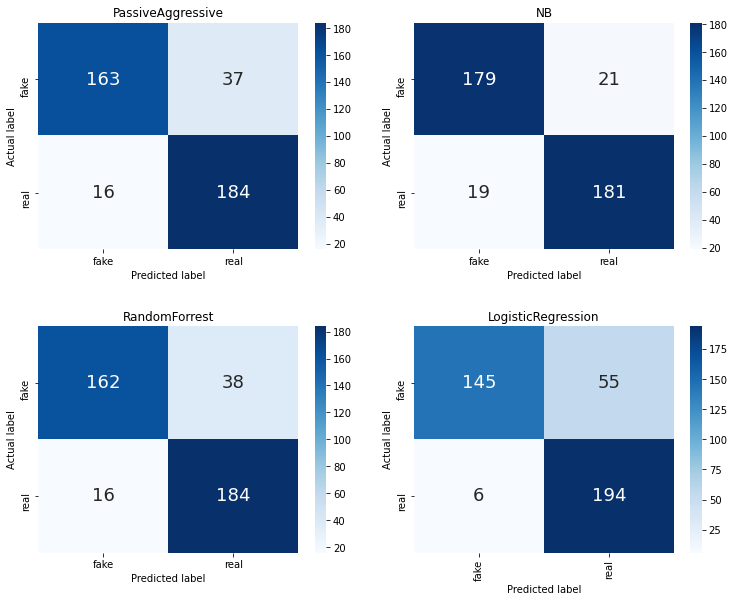

In [187]:
# Lets Compare the models interms of the True Negatives(Fake News Classified as fake) and False Positives (Fake News Classified as real)
# Let See the Confusion Matrix plot for each classifier under consideration based on the title
fig,axes=plt.subplots(2,2,)
fig.set_figheight(9)
fig.set_figwidth(11)
plotConfusionMatrix(title_pa_cm,'PassiveAggressive',axes[0,0])
plotConfusionMatrix(title_nb_cm,'NB',axes[0,1])
plotConfusionMatrix(title_rf_cm,'RandomForrest',axes[1,0])
plotConfusionMatrix(title_lg_cm,'LogisticRegression',axes[1,1])

The title of an article can be considered the overview of the article content. As such before reading the article, we should be able to estimate if the proceeding content is fake or real. However as shown above, models (PassiveAggressive, Logistic and RandomForrestClassifier) have higher number of fake articles classified as real news. These models might need additional information to improve their peformance.

In [149]:
def evalModel(X_test,y_test,pipe_classifier,labelEncoder):
    y_pred = pipe_classifier.predict(X_test)
    print(classification_report(y_test,y_pred))

    # Get the Confusion Matrix
    cm= confusion_matrix(labelEncoder.inverse_transform(y_test),
                          labelEncoder.inverse_transform(y_pred),
                        )
    cmatrix=ExtractConfusionMatrixEntries(cm,'')
    plotConfusionMatrix(cm,title='Confusion Matrix Plot',axis=None)
    return cm

              precision    recall  f1-score   support

           0       0.90      0.83      0.86       200
           1       0.84      0.91      0.87       200

    accuracy                           0.87       400
   macro avg       0.87      0.87      0.87       400
weighted avg       0.87      0.87      0.87       400



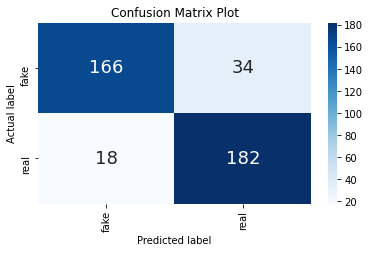

In [29]:
#Optimize the random forest classifier parameters
parameters = {
    #'sent_trans__max_df':(0.5,0.6,0.7),
    'sent_trans__ngram_range': [(1, 2),(1,3),],
               #'classifier__max_depth': (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15),
    'classifier__n_estimators':(300,500,2000,4000)
}

gs_title_rf_clf = GridSearchCV(title_rf_pipe_classifier, parameters, n_jobs=-1)
gs_title_rf_clf.fit(X_train_title,y_train)

# Lets see the best classifier returned
#print(gs_title_rf_clf.best_estimator_)


              precision    recall  f1-score   support

           0       0.90      0.83      0.86       200
           1       0.84      0.91      0.87       200

    accuracy                           0.87       400
   macro avg       0.87      0.87      0.87       400
weighted avg       0.87      0.87      0.87       400



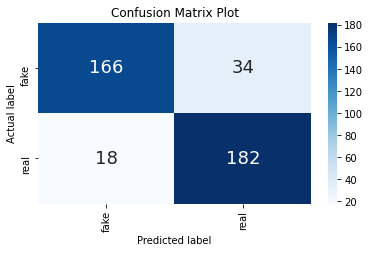

In [109]:
# Evaluate performance
title_rf_opt_cm=evalModel(X_test_title,y_test,gs_title_rf_clf.best_estimator_)

 From above it looks like we were able to reduce the number of False Positives so we will use this as the final title classifier

In [30]:
# PassiveAggressive
#Optimize the rclassifier parameters
parameters = {
    'sent_trans__max_df':(0.4,0.5,0.6,0.7),
    'sent_trans__ngram_range': [(1, 1), (1, 2),(1,3),(1,4),(1,5)],
               #'classifier__max_depth': (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15),
    'classifier__max_iter':(200,500,2000,1000,3000,),
    'classifier__loss':['squared_hinge','hinge']
}

gs_title_pa_clf = GridSearchCV(title_pa_pipe_classifier, parameters, n_jobs=-1)
gs_title_pa_clf = gs_title_pa_clf.fit(X_train_title,y_train)

              precision    recall  f1-score   support

           0       0.92      0.85      0.89       200
           1       0.86      0.93      0.89       200

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.89      0.89      0.89       400



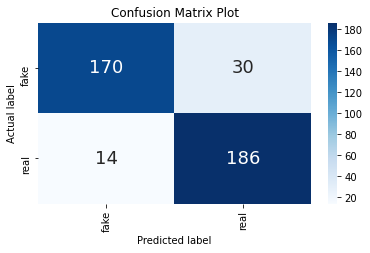

In [91]:
title_pa_opt_cm=evalModel(X_test_title,y_test,gs_title_pa_clf.best_estimator_)
#  From below it looks like we were able to reduce the number of False Positives 
# so we will use this as the final title classifier

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       200
           1       0.90      0.91      0.90       200

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.90       400



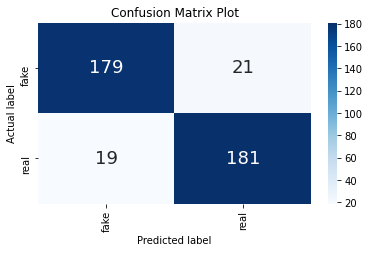

In [37]:
# multinormialNB
#Optimize the classifier parameters
parameters = {
    'sent_trans__max_df':(0.4,0.5,0.6,0.7,0.8,0.2),
    'sent_trans__ngram_range': [(1, 1), (1, 2),(1,3),(1,4),(1,5)],
               #'classifier__max_depth': (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15),
    #'classifier__max_iter':(200,500,2000,1000,3000,),
    'classifier__alpha':(1e-3,2e-3,1e-4,1e-2)
}

gs_title_nb_clf = GridSearchCV(title_nb_pipe_classifier, parameters, n_jobs=-1)
gs_title_nb_clf = gs_title_nb_clf.fit(X_train_title,y_train)

#  From below it looks like no difference in performance before the optimization

              precision    recall  f1-score   support

           0       0.89      0.96      0.92       200
           1       0.96      0.88      0.92       200

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.92       400
weighted avg       0.92      0.92      0.92       400



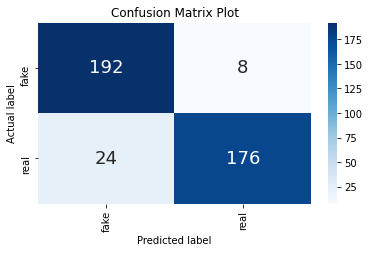

In [98]:
title_nb_opt_cm=evalModel(X_test_title,y_test,gs_title_nb_clf.best_estimator_)

In [147]:
# LogisticRegression
#Optimize the classifier parameters
parameters = {
    'sent_trans__max_df':(0.4,0.5,0.6,0.7,0.8,0.2),
    'sent_trans__ngram_range': [(1, 1), (1, 2),(1,3),(1,4),(1,5)],
               #'classifier__max_depth': (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15),
    'classifier__penalty': ('l1', 'l2', 'elasticnet', 'none'),
    'classifier__max_iter':(200,500,2000,1000,3000,),
    
}

gs_title_lg_clf = GridSearchCV(title_lg_pipe_classifier, parameters, n_jobs=-1)
gs_title_lg_clf = gs_title_lg_clf.fit(X_train_title,y_train)

              precision    recall  f1-score   support

           0       0.94      0.77      0.84       200
           1       0.80      0.95      0.87       200

    accuracy                           0.86       400
   macro avg       0.87      0.86      0.86       400
weighted avg       0.87      0.86      0.86       400



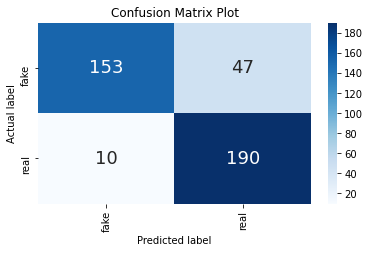

In [151]:
title_lg_opt_cm=evalModel(X_test_title,y_test,gs_title_lg_clf.best_estimator_,labelEncoder)
#  From below it looks there is a significant reduction in the number of False positive predictions (from 55 to 47)
# We will use this as the final model

In [59]:
# Case 2: Classifier news items based on only the text content
# Generate the Vectorizers for only the title content
X_train_text= dataprep(df_all_articles.text.values)
X_test_text = dataprep(df_all_articles_test.text.values)

# Build and fit the TFIDF Vectorizer
text_document_vectorizer = TfidfVectorizer(max_df=0.7, 
                                            ngram_range=(1,4),
                                            use_idf=True,
                                            stop_words= nltk.corpus.stopwords.words('english'))
_x = text_document_vectorizer.fit_transform(X_train_text)

# Build and fit the BOW Vectorizer
text_bow_vectorizer = CountVectorizer(stop_words= nltk.corpus.stopwords.words('english'))

X_train_text= df_all_articles.text.values
X_test_text = df_all_articles_test.text.values

In [63]:
# Train The PassiveAggressive Classifier
print('PassiveAggressive Classifier')
# Model 1: PassiveAggressiveClassifier
text_pa_pipe_classifier,text_pa_y_pred,text_pa_cmatrix,text_pa_cm = fitEvalModel(X_train_text,
                                              y_train,text_document_vectorizer,
                                              PassiveAggressiveClassifier(),
                                              BasicPreprocessor(),
                                              'PassiveAggressive', X_test_text,
                                              y_test,labelEncoder,plot_cm=False)


# Model 3: RandomForest
print('RandomForest')
# We increase the number of estimators here to accomodate for the large document size
text_rf_pipe_classifier,text_rf_y_pred,text_rf_cmatrix,text_rf_cm = fitEvalModel(X_train_text,
                                              y_train,text_document_vectorizer,
                                              RandomForestClassifier(n_estimators=3000,),
                                              BasicPreprocessor(),
                                              'randomforrest', X_test_text,
                                              y_test,labelEncoder,plot_cm=False)

# Model 4: MultinomrmialNB
print('MultinomrmialNB')
text_nb_pipe_classifier,text_nb_y_pred,text_nb_cmatrix,text_nb_cm = fitEvalModel(X_train_text,
                                              y_train,text_document_vectorizer,
                                              MultinomialNB(alpha=1e-3),
                                              BasicPreprocessor(),
                                              'MultinomialNB', X_test_text,
                                              y_test,labelEncoder,plot_cm=False)

PassiveAggressive Classifier
BasicPreprocessor()
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       200
           1       0.97      0.98      0.98       200

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400

LogisticClassifier
BasicPreprocessor()
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       200
           1       0.89      0.99      0.94       200

    accuracy                           0.93       400
   macro avg       0.94      0.93      0.93       400
weighted avg       0.94      0.93      0.93       400

RandomForest
BasicPreprocessor()
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       200
           1       0.94      0.97      0.95       200

    accuracy                           0.95       400
   macr

In [65]:
# Model 2: LogisticClassifier
print('LogisticClassifier')
text_lg_pipe_classifier,text_lg_y_pred,text_lg_cmatrix,text_lg_cm = fitEvalModel(X_train_text,
                                              y_train,text_document_vectorizer,
                                              LogisticRegression(max_iter=2000,),
                                              BasicPreprocessor(),
                                              'logistic', X_test_text,
                                              y_test,labelEncoder,plot_cm=False)


LogisticClassifier
BasicPreprocessor()
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       200
           1       0.89      0.99      0.94       200

    accuracy                           0.93       400
   macro avg       0.94      0.93      0.93       400
weighted avg       0.94      0.93      0.93       400



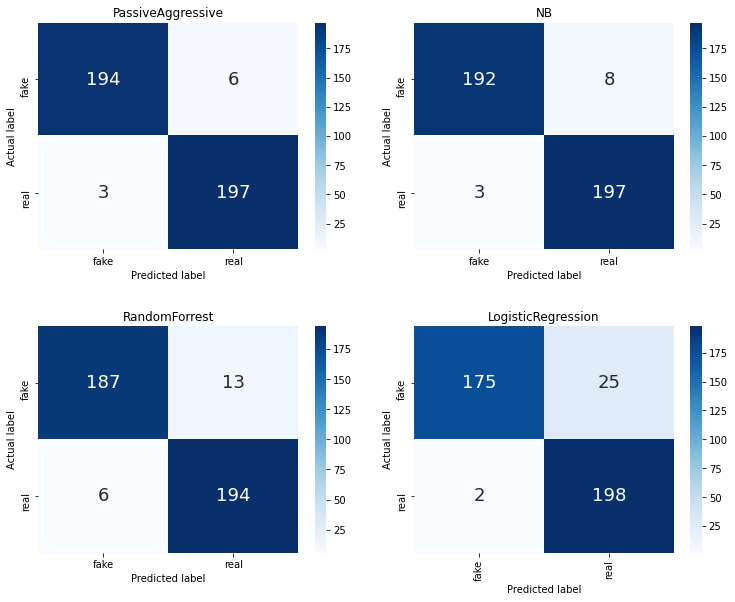

In [70]:
# Lets Compare the models interms of the True Negatives(Fake News Classified as fake) and False Positives (Fake News Classified as real)
# Let See the Confusion Matrix plot for each classifier under consideration based on the title
fig,axes=plt.subplots(2,2,)
fig.set_figheight(9)
fig.set_figwidth(11)
plotConfusionMatrix(text_pa_cm,'PassiveAggressive',axes[0,0])
plotConfusionMatrix(text_nb_cm,'NB',axes[0,1])
plotConfusionMatrix(text_rf_cm,'RandomForrest',axes[1,0])
plotConfusionMatrix(text_lg_cm,'LogisticRegression',axes[1,1])

In [ ]:
# As shown above, training on the news body only produced significant performancee compared to using only the title
# The best performing models are the PassiveAggressive and the NB models

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       200
           1       0.94      0.97      0.96       200

    accuracy                           0.96       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.96      0.96      0.96       400



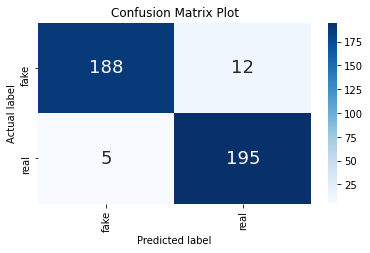

In [92]:
#Optimize the random forest classifier parameters
parameters = {
    #'sent_trans__max_df':(0.5,0.6,0.7),
    'sent_trans__ngram_range': [(1, 2),(1,3),],
               #'classifier__max_depth': (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15),
    'classifier__n_estimators':(300,500,2000,4000)
}

gs_text_rf_clf = GridSearchCV(text_rf_pipe_classifier, parameters, n_jobs=-1)
gs_text_rf_clf.fit(X_train_text,y_train)

# Lets see the best classifier returned
#print(gs_title_rf_clf.best_estimator_)


              precision    recall  f1-score   support

           0       0.97      0.94      0.96       200
           1       0.94      0.97      0.96       200

    accuracy                           0.96       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.96      0.96      0.96       400



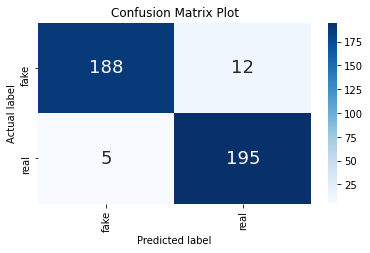

In [95]:
# Evaluate performance
text_rf_opt_cm=evalModel(X_test_text,y_test,gs_text_rf_clf.best_estimator_)

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       200
           1       0.96      0.99      0.98       200

    accuracy                           0.97       400
   macro avg       0.98      0.97      0.97       400
weighted avg       0.98      0.97      0.97       400



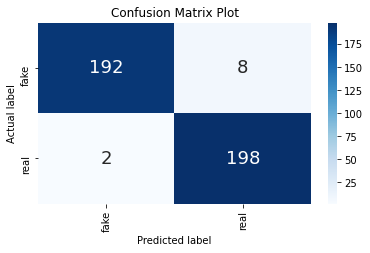

In [69]:
# The Logistic Regression performed poorly so let try to improve it
# LogisticRegression
#Optimize the classifier parameters
parameters = {
    'sent_trans__max_df':(0.4,0.5,0.6,0.7,0.8,0.2),
    'sent_trans__ngram_range': [(1, 1), (1, 2),(1,3),(1,4),(1,5)],
               #'classifier__max_depth': (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15),
    'classifier__penalty': ('l1', 'l2', 'elasticnet', 'none'),
    'classifier__max_iter':(200,500,2000,1000,3000,),
    
}

gs_text_lg_clf = GridSearchCV(text_lg_pipe_classifier, parameters, n_jobs=-1)
gs_text_lg_clf = gs_title_lg_clf.fit(X_train_text,y_train)

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       200
           1       0.96      0.99      0.98       200

    accuracy                           0.97       400
   macro avg       0.98      0.97      0.97       400
weighted avg       0.98      0.97      0.97       400



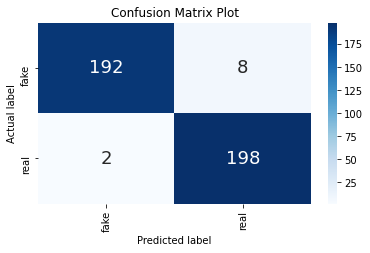

In [103]:
text_lg_opt_cm=evalModel(X_test_text,y_test,gs_text_lg_clf.best_estimator_)
#  From below it looks there is a significant reduction in the number of False positive predictions (from 25 to 8)
# We will use this as the final model

['pretrained/textclassifiers//logistic.joblib']

In [75]:
# Case 3: Training data consisting of both the title and the text

# Generate the Vectorizers
X_train= dataprep(df_all_articles.news_content.values)
X_test = dataprep(df_all_articles_test.news_content.values)

# Build and fit the TFIDF Vectorizer
document_vectorizer = TfidfVectorizer(max_df=0.7, 
                                      max_features=30000,
                                      ngram_range=(1,3),use_idf=True,
                             stop_words= nltk.corpus.stopwords.words('english'))
X_train_ = document_vectorizer.fit_transform(X_train)
X_test_ = document_vectorizer.transform(X_test)

# Build and fit the BOW Vectorizer
bow_vectorizer = CountVectorizer(stop_words= nltk.corpus.stopwords.words('english'))
_x = bow_vectorizer.fit_transform(X_train)
X_train_ = bow_vectorizer.fit_transform(X_train)
X_train_content= df_all_articles.news_content.values
X_test_content = df_all_articles_test.news_content.values

# Train The PassiveAggressive Classifier
print('PassiveAggressive Classifier')
# Model 1: PassiveAggressiveClassifier
content_pa_pipe_classifier,content_pa_y_pred,content_pa_cmatrix,content_pa_cm = fitEvalModel(X_train_content,
                                              y_train,document_vectorizer,
                                              PassiveAggressiveClassifier(),
                                              BasicPreprocessor(),
                                              'PassiveAggressive', X_test_content,
                                              y_test,labelEncoder,plot_cm=False)

# Model 2: LogisticClassifier
print('LogisticClassifier')
content_lg_pipe_classifier,content_lg_y_pred,content_lg_cmatrix,content_lg_cm = fitEvalModel(X_train_content,
                                              y_train,document_vectorizer,
                                              LogisticRegression(max_iter=2000,),
                                              BasicPreprocessor(),
                                              'logistic', X_test_content,
                                              y_test,labelEncoder,plot_cm=False)

# Model 3: RandomForest
print('RandomForest')
# We increase the number of estimators here to accomodate for the large document size
content_rf_pipe_classifier,content_rf_y_pred,content_rf_cmatrix,content_rf_cm = fitEvalModel(X_train_content,
                                              y_train,document_vectorizer,
                                              RandomForestClassifier(n_estimators=3000,),
                                              BasicPreprocessor(),
                                              'randomforrest', X_test_content,
                                              y_test,labelEncoder,plot_cm=False)

# Model 4: MultinomrmialNB
print('MultinomrmialNB')
content_nb_pipe_classifier,content_nb_y_pred,content_nb_cmatrix,content_nb_cm = fitEvalModel(X_train_content,
                                              y_train,document_vectorizer,
                                              MultinomialNB(alpha=1e-4),
                                              BasicPreprocessor(),
                                              'MultinomialNB', X_test_content,
                                              y_test,labelEncoder,plot_cm=False)

PassiveAggressive Classifier
BasicPreprocessor()
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       200
           1       0.99      0.99      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400

LogisticClassifier
BasicPreprocessor()
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       200
           1       0.96      0.99      0.97       200

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400

RandomForest
BasicPreprocessor()
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       200
           1       0.93      0.98      0.96       200

    accuracy                           0.95       400
   macr

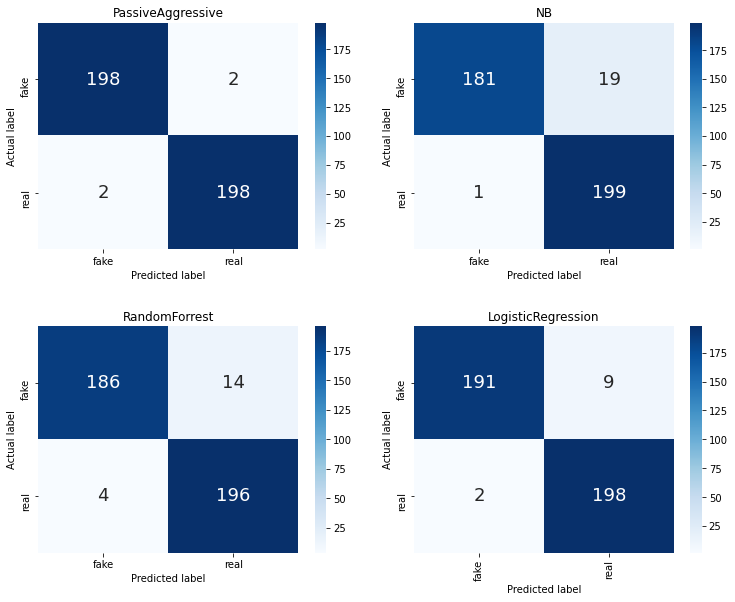

In [76]:
# Lets Compare the models interms of the True Negatives(Fake News Classified as fake) and False Positives (Fake News Classified as real)
# Let See the Confusion Matrix plot for each classifier under consideration based on the title
fig,axes=plt.subplots(2,2,)
fig.set_figheight(9)
fig.set_figwidth(11)
plotConfusionMatrix(content_pa_cm,'PassiveAggressive',axes[0,0])
plotConfusionMatrix(content_nb_cm,'NB',axes[0,1])
plotConfusionMatrix(content_rf_cm,'RandomForrest',axes[1,0])
plotConfusionMatrix(content_lg_cm,'LogisticRegression',axes[1,1])

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       200
           1       0.97      0.98      0.98       200

    accuracy                           0.97       400
   macro avg       0.98      0.97      0.97       400
weighted avg       0.98      0.97      0.97       400



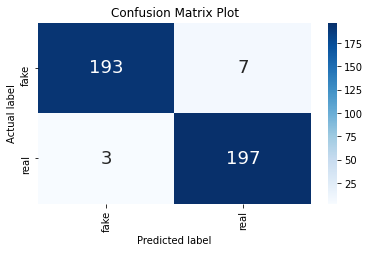

In [77]:
# Lets try to improve the performance of the RandomForest and NB models
# multinormialNB
#Optimize the classifier parameters
parameters = {
    'sent_trans__max_df':(0.4,0.5,0.6,0.7,0.8,0.2),
    'sent_trans__ngram_range': [(1, 1), (1, 2),(1,3),(1,4),(1,5)],
               #'classifier__max_depth': (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15),
    #'classifier__max_iter':(200,500,2000,1000,3000,),
    'classifier__alpha':(1e-3,2e-3,1e-4,1e-2)
}

gs_content_nb_clf = GridSearchCV(content_nb_pipe_classifier, parameters, n_jobs=-1)
gs_content_nb_clf = gs_title_nb_clf.fit(X_train_content,y_train)


              precision    recall  f1-score   support

           0       0.98      0.96      0.97       200
           1       0.97      0.98      0.98       200

    accuracy                           0.97       400
   macro avg       0.98      0.97      0.97       400
weighted avg       0.98      0.97      0.97       400



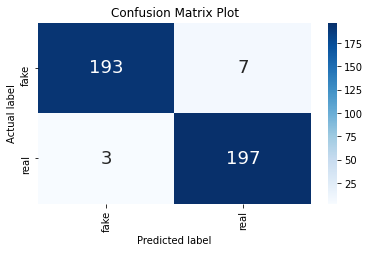

In [113]:
content_nb_opt_cm=evalModel(X_test_content,y_test,gs_content_nb_clf.best_estimator_)
#  From below it looks like significant improvement in the performance after the optimization

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       200
           1       0.94      0.98      0.96       200

    accuracy                           0.96       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.96      0.96      0.96       400



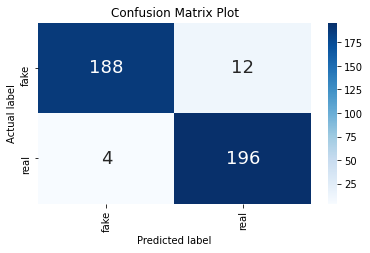

In [78]:
#Optimize the random forest classifier parameters
parameters = {
    #'sent_trans__max_df':(0.5,0.6,0.7),
    'sent_trans__ngram_range': [(1, 2),(1,3),],
               #'classifier__max_depth': (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15),
    'classifier__n_estimators':(300,500,2000,4000)
}

gs_content_rf_clf = GridSearchCV(content_rf_pipe_classifier, parameters, n_jobs=-1)
gs_content_rf_clf.fit(X_train_content,y_train)

# Lets see the best classifier returned
#print(gs_title_rf_clf.best_estimator_)
# Evaluate performance


              precision    recall  f1-score   support

           0       0.98      0.94      0.96       200
           1       0.94      0.98      0.96       200

    accuracy                           0.96       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.96      0.96      0.96       400



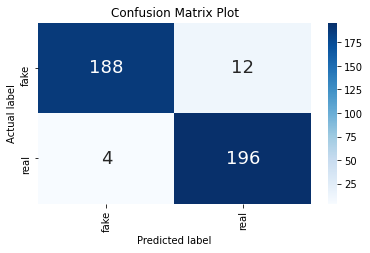

In [105]:
content_rf_opt_cm=evalModel(X_test_content,y_test,gs_content_rf_clf.best_estimator_)

In [189]:
title_lg_opt_cm

array([[153,  47],
       [ 10, 190]])

In [ ]:
# Analyzing the overall performance of each model

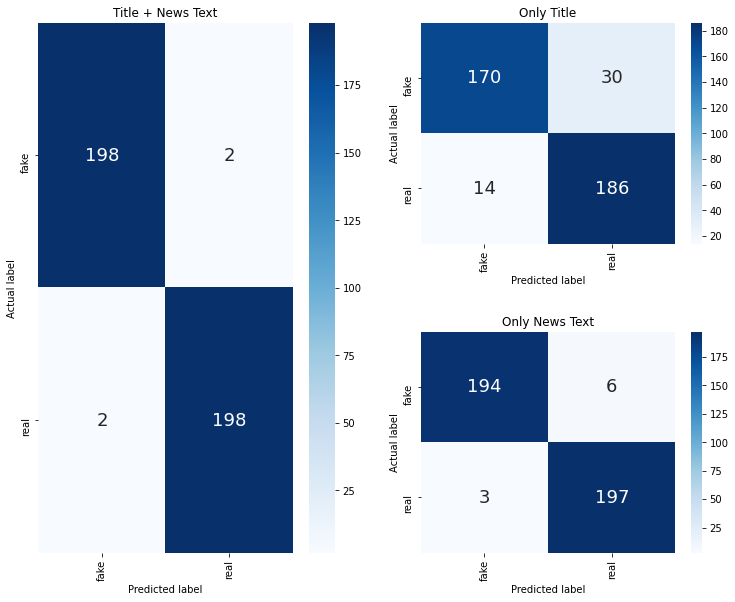

In [89]:
# Performance of the PassiveAggressiveModel
fig = plt.figure(figsize=(11,9))
plotConfusionMatrix(title_pa_opt_cm,'Only Title',plt.subplot(222))
plotConfusionMatrix(text_pa_cm,'Only News Text',plt.subplot(224))
plotConfusionMatrix(content_pa_cm,'Title + News Text',plt.subplot(121))
#plt.title('oos')

As shown above, the PassiveAggressive classifier performs poorly when classifying based on only the title. There is ncrease in the detection of actual fake news when the text content is used inplace of the text. Overall, it achieves best performance when trained on both the title and the text content.

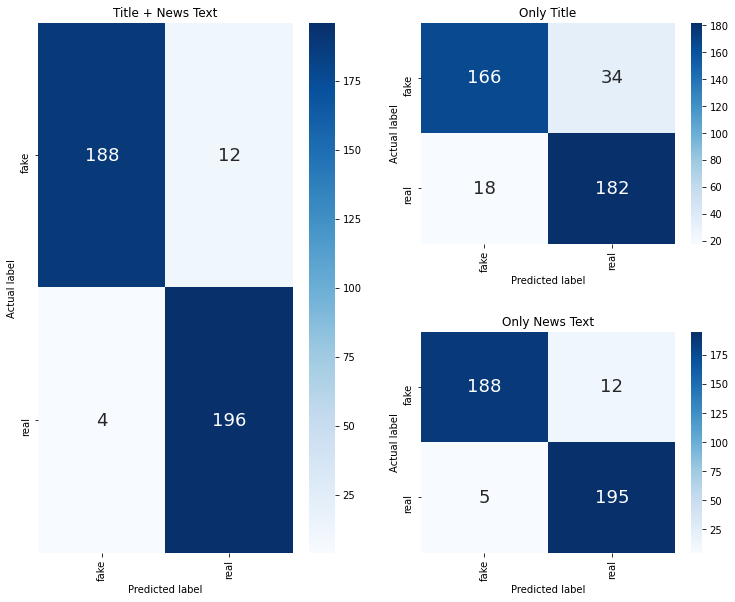

In [110]:
# Analyzing the pverall performance of each model
# RandomForestModels
fig = plt.figure(figsize=(11,9))
plotConfusionMatrix(title_rf_opt_cm,'Only Title',plt.subplot(222))
plotConfusionMatrix(text_rf_opt_cm,'Only News Text',plt.subplot(224))
plotConfusionMatrix(content_rf_opt_cm,'Title + News Text',plt.subplot(121))
#plt.title('oos')

In [ ]:
# The title doesn't Contribute to reduction of the number of False Positives, Using only the text seem better option

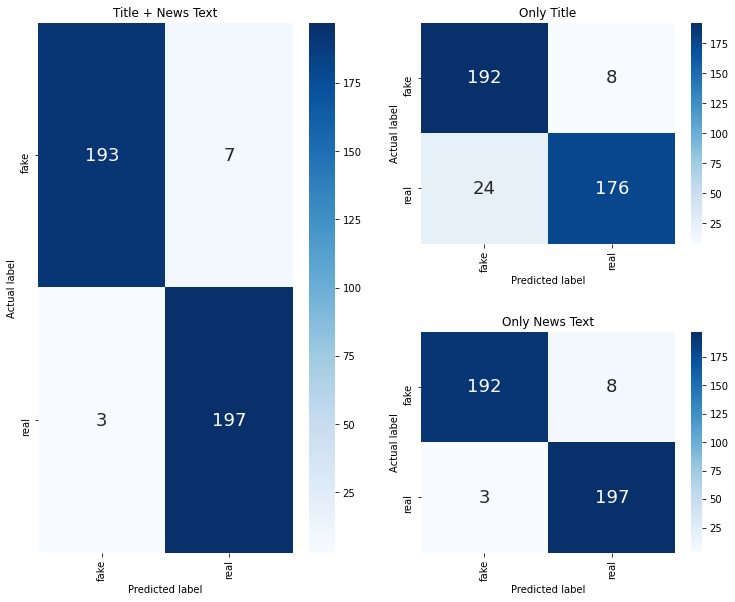

In [114]:
# Analyzing the pverall performance of each model
# MultinormialNB
fig = plt.figure(figsize=(11,9))
plotConfusionMatrix(title_nb_opt_cm,'Only Title',plt.subplot(222))
plotConfusionMatrix(text_nb_cm,'Only News Text',plt.subplot(224))
plotConfusionMatrix(content_nb_opt_cm,'Title + News Text',plt.subplot(121))

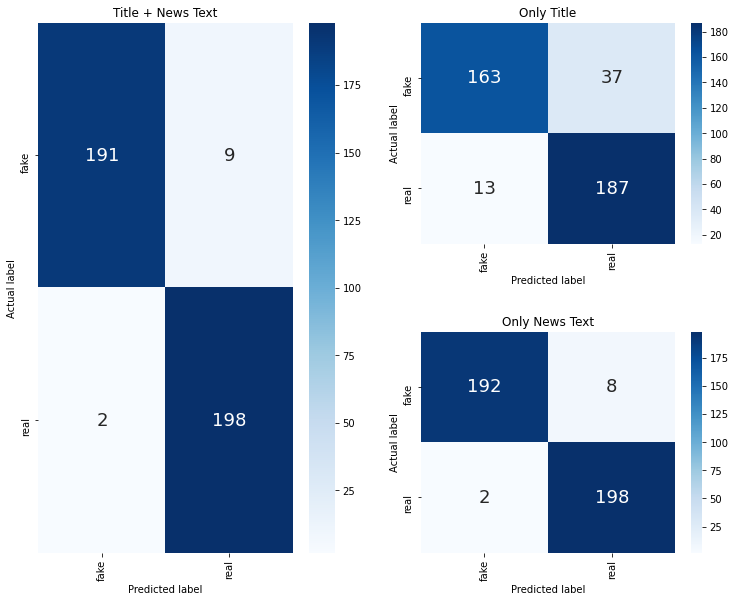

In [106]:
# Analyzing the pverall performance of each model
# LogisticRegression
fig = plt.figure(figsize=(11,9))
plotConfusionMatrix(title_lg_opt_cm,'Only Title',plt.subplot(222))
plotConfusionMatrix(text_lg_opt_cm,'Only News Text',plt.subplot(224))
plotConfusionMatrix(content_lg_cm,'Title + News Text',plt.subplot(121))

In [130]:
#pk.dump(labelEncoder,open('pretrained/label_encoder.tp','wb'))
# save all the trained model for deployment using joblib
from joblib import dump,load
import os
# Save the best models Trained on only the titles
#os.mkdir('pretrained/documentclassifiers/')
title_classifier_paths= 'pretrained/titleclassifiers/'
text_classifier_paths= 'pretrained/textclassifiers/' 
full_content_classifier_path =  'pretrained/documentclassifiers/'

#Compress and save the models to save space
#save the Title Classiifier models
dump(gs_title_rf_clf.best_estimator_,title_classifier_paths+'/rf.bz2',compress=('bz2',3))
dump(gs_title_pa_clf.best_estimator_,title_classifier_paths+'/pa.bz2',compress=('bz2',3))
dump(gs_title_nb_clf.best_estimator_,title_classifier_paths+'/nb.bz2',compress=('bz2',3))
dump(gs_title_lg_clf.best_estimator_,title_classifier_paths+'/logistic.bz2',compress=('bz2',3))

#Save the text Classifiers
dump(gs_text_rf_clf.best_estimator_,text_classifier_paths+'/rf.bz2',compress=('bz2',3))
dump(text_pa_pipe_classifier,text_classifier_paths+'/pa.bz2',compress=('bz2',3))
dump(text_nb_pipe_classifier,text_classifier_paths+'/nb.bz2',compress=('bz2',3))
dump(gs_text_lg_clf.best_estimator_,text_classifier_paths+'/logistic.bz2',compress=('bz2',3))

#save the full_Content Classiifier models
dump(gs_content_rf_clf.best_estimator_,full_content_classifier_path+'/rf.bz2',compress=('bz2',3))
dump(content_pa_pipe_classifier,full_content_classifier_path+'/pa.bz2',compress=('bz2',3))
dump(gs_content_nb_clf.best_estimator_,full_content_classifier_path+'/nb.bz2',compress=('bz2',3))


['pretrained/documentclassifiers//logistic..bz2']

### Case 4: Assigning the probability of fakery based on the domain name: is that possible and trustworthy


In [38]:
# Generate the Vectorizers
X_train= dataprep(df_all_articles.url.values)
X_test = dataprep(df_all_articles_test.url.values)

# Build and fit the TFIDF Vectorizer
domain_vectorizer = TfidfVectorizer( )
X_train_ = domain_vectorizer.fit_transform(X_train)
X_test_ = domain_vectorizer.transform(X_test)

# Build and fit the BOW Vectorizer
bow_vectorizer = CountVectorizer(stop_words= nltk.corpus.stopwords.words('english'))
_x = bow_vectorizer.fit_transform(X_train)
X_train_ = bow_vectorizer.fit_transform(X_train)
X_train_domain= df_all_articles.url.values
X_test_domain = df_all_articles_test.url.values


In [39]:
X_train_.todense().shape,_x.shape

((1600, 5224), (1600, 5224))

In [40]:
X_train[0]

'https www kolalwatn net news375220'

In [41]:
# Train The PassiveAggressive Classifier
print('PassiveAggressive Classifier')
# Model 1: PassiveAggressiveClassifier
domain_pa_pipe_classifier,domain_pa_y_pred,domain_pa_cmatrix,domain_pa_cm = fitEvalModel(X_train_domain,
                                              y_train,domain_vectorizer,
                                              PassiveAggressiveClassifier(),
                                              BasicPreprocessor(),
                                              'PassiveAggressive', X_test_domain,
                                              y_test,labelEncoder,plot_cm=False)

PassiveAggressive Classifier
BasicPreprocessor()
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       200
           1       0.99      1.00      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



In [46]:


# Model 2: LogisticClassifier
print('LogisticClassifier')
domain_lg_pipe_classifier,domain_lg_y_pred,domain_lg_cmatrix,domain_lg_cm = fitEvalModel(X_train_domain,
                                              y_train,domain_vectorizer,
                                              LogisticRegression(),
                                              BasicPreprocessor(),
                                              'logistic', X_test_domain,
                                              y_test,labelEncoder,plot_cm=False)

# Model 3: RandomForest
print('RandomForest')
# We increase the number of estimators here to accomodate for the large document size
domain_rf_pipe_classifier,domain_rf_y_pred,domain_rf_cmatrix,domain_rf_cm = fitEvalModel(X_train_domain,
                                              y_train,domain_vectorizer,
                                              RandomForestClassifier(random_state=45,),
                                              BasicPreprocessor(),
                                              'randomforrest', X_test_domain,
                                              y_test,labelEncoder,plot_cm=False)

# Model 4: MultinomrmialNB
print('MultinomrmialNB')
domain_nb_pipe_classifier,domain_nb_y_pred,domain_nb_cmatrix,domain_nb_cm = fitEvalModel(X_train_domain,
                                              y_train,domain_vectorizer,
                                              MultinomialNB(alpha=1e-4),
                                              BasicPreprocessor(),
                                              'MultinomialNB', X_test_domain,
                                              y_test,labelEncoder,plot_cm=False)

LogisticClassifier
BasicPreprocessor()
              precision    recall  f1-score   support

           0       1.00      0.95      0.98       200
           1       0.96      1.00      0.98       200

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400

RandomForest
BasicPreprocessor()
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       1.00      1.00      1.00       200

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400

MultinomrmialNB
BasicPreprocessor()
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       200
           1       0.93      0.99      0.96       200

    accuracy                           0.96       400
   macro avg       0

In [60]:
exp_url = 'https://bbcAfrica.2b.com/b/'
domain_pa_pipe_classifier.predict([exp_url]),domain_nb_pipe_classifier.predict([exp_url]),domain_rf_pipe_classifier.predict([exp_url])

(array([0]), array([1]), array([0]))

(array([1]), array([1]))

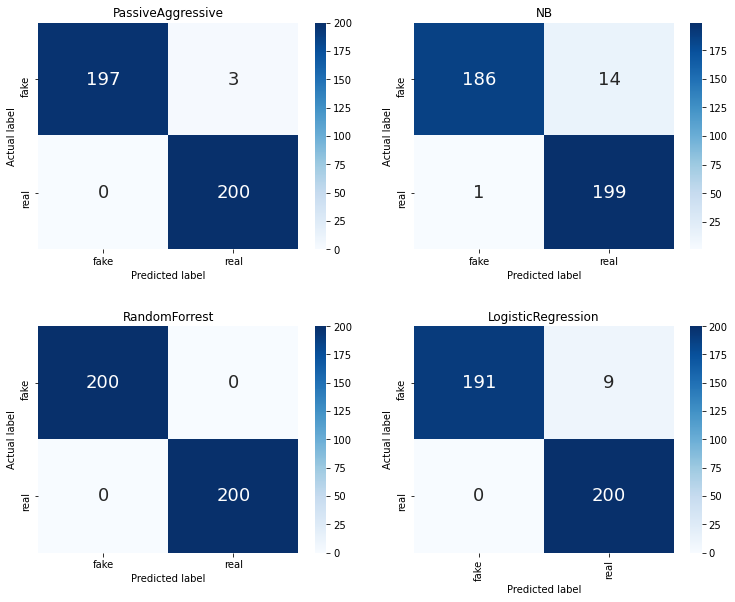

In [47]:
fig,axes=plt.subplots(2,2,)
fig.set_figheight(9)
fig.set_figwidth(11)
plotConfusionMatrix(domain_pa_cm,'PassiveAggressive',axes[0,0])
plotConfusionMatrix(domain_nb_cm,'NB',axes[0,1])
plotConfusionMatrix(domain_rf_cm,'RandomForrest',axes[1,0])
plotConfusionMatrix(domain_lg_cm,'LogisticRegression',axes[1,1])

As shown training the models based the urls of the new articles can results in a url filtering model that can be used as the initial step to identifying
the potential fake news content. All models did remarkably well especially the Linear models and the Randomforest model. For a much more efficient system, you will need more datasets

## Looking under the hood to identify words or ngrams assigned the larget and smallest coefficient values.

In [61]:
# Which Word influences the performance of each classifier?
# Lets Take a look under the hood to identify the words influcing the decision with respect to each class
# Words assigned the lowest coef by each model
def classifierCoef(classifier, feature_name,n=30):
    feature_names = np.array(feature_name)
    try:
        sorted_coef_index = classifier.coef_[0].argsort()
    except:
        try:
            sorted_coef_index = classifier.feature_importances_.argsort()
            #sorted(zip( classifier.feature_importances_,feature_names,))
        except:
            return
            pass
    print(f'Smallest Coef: \n{feature_names[sorted_coef_index][:n]}\n')
    print(f'Largest Coef: \n{feature_names[sorted_coef_index][:-(n+1):-1]}\n')

In [62]:
#URL Classifier
# Logistic Regression
classifierCoef(domain_lg_pipe_classifier.named_steps['classifier'], domain_vectorizer.get_feature_names(),n=30)

Smallest Coef: 
['ru' 'net' 'http' 'org' 'd8' 'd9' 'html' 'youtube' 'watch' 'info'
 'sputniknews' 'front' 'albidda' 'southfront' 'archives' 'id' 'rt' 'php'
 'article' 'koronavirus' 'de' 'lomazoma' 'sputnik' 'tv' 'details' 'op'
 'ed' 'turess' 'sy' 'ar']

Largest Coef: 
['coronavirus' 'apnews' 'axios' 'bbc' '2020' 'com' 'www' 'to' 'err' 'ee'
 'uk' 'wsj' 'yle' 'fi' 'osasto' 'uutiset' 'dw' 'theatlantic'
 'themoscowtimes' 'in' 'economist' 'thetimes' 'theguardian' 'nytimes'
 'euronews' 'articles' 'the' 'archive' 'for' 'on']



In [63]:
# NB
classifierCoef(domain_nb_pipe_classifier.named_steps['classifier'], domain_vectorizer.get_feature_names(),n=30)

Smallest Coef: 
['00' 'kgb' 'khabar102875' 'khabar106525' 'khabaralyoum' 'khabarlb'
 'khabarmasr' 'khaberni' 'khabr' 'khafaya101469' 'khafaya97106'
 'khafaya97250' 'khafayalb' 'khayli' 'khazin' 'khelovnurad' 'khlfh'
 'kijev' 'kijevben' 'kirill' 'kissinger' 'kitae' 'keszult' 'kitaiskii'
 'kde' 'katyusha' 'jepidemiju' 'jeto' 'ji' 'jimare']

Largest Coef: 
['com' 'https' 'www' 'coronavirus' '2020' 'news' 'apnews' 'the' 'bbc'
 'world' '03' 'to' 'fi' 'yle' 'osasto' 'uutiset' 'in' '04' 'uk' 'of'
 'covid' '19' 'html' 'ee' 'err' 'theatlantic' 'dw' '02' 'axios' 'thetimes']



In [64]:
# PassiveAggressive
classifierCoef(domain_pa_pipe_classifier.named_steps['classifier'], domain_vectorizer.get_feature_names(),n=30)

Smallest Coef: 
['ru' 'org' 'http' 'net' 'sputniknews' 'https' 'rt' 'archives'
 'southfront' 'info' 'front' 'html' 'almaalomah' 'php' 'youtube' 'sputnik'
 'tv' 'de' 'watch' 'turess' 'lomazoma' 'article' 'htm' 'geopolitica' 'ar'
 'index' 'details' 'ed' 'op' 'sabaharabi']

Largest Coef: 
['axios' 'coronavirus' 'bbc' 'apnews' 'ee' 'err' 'wsj' 'nytimes'
 'themoscowtimes' 'economist' 'theatlantic' 'dw' 'to' 'uk' 'euronews'
 '2020' 'time' 'www' 'theguardian' 'thetimes' 'yle' 'fi' 'uutiset'
 'osasto' 'reuters' 'on' 'articles' 'archive' 'in' 'co']



In [65]:
# RandomForest
classifierCoef(domain_rf_pipe_classifier.named_steps['classifier'], domain_vectorizer.get_feature_names(),n=30)

Smallest Coef: 
['forced' 'c2' 'c33c70d5' 'rosja' 'romanian' 'c8f66d0e' 'c96178403ef7'
 'c07b' 'c9b3' 'cadets' 'rocne' 'calm' 'robot' 'camp' 'camps' 'rohingya'
 'rossija' 'rossijskoj' 'businesses' 'breznu' 'rumored' 'rueconomics'
 'britains' 'briton' 'rubric' 'brote' 'brzy' 'routine' 'rossiyskoy'
 'rossiyskiy']

Largest Coef: 
['com' 'https' 'coronavirus' 'www' 'ru' 'html' 'apnews' '2020' 'net'
 'news' 'bbc' 'http' 'ee' 'uutiset' 'd8' 'axios' '8a' 'uk' 'yle' 'wsj'
 '86' 'to' '83' 'err' '88' 'osasto' 'the' 'b1' 'world' 'sputniknews']



In [268]:
# Title Classification Models

In [269]:
# Logistic Regression
classifierCoef(title_lg_pipe_classifier.named_steps['classifier'], title_document_vectorizer.get_feature_names(),n=30)

Smallest Coef: 
['corona' 'corona virus' 'biological' 'page' 'virus' 'available'
 'page available' 'epidemic' 'russia' 'behind' 'gates' 'bill' 'bill gates'
 'report' 'secret' 'us' 'russian' 'theory' 'spread corona' 'china'
 'conspiracy theory' 'conspiracy' 'immunity' 'space' 'weapon' 'spread'
 'ukraine' 'european' 'american' 'union']

Largest Coef: 
['coronavirus' 'dw' 'cases' 'deaths' 'finland' 'hospital' 'home' 'tests'
 'ship' 'atlantic' 'cruise' 'amid' 'latest' 'covid' 'positive' 'politics'
 'cruise ship' 'daily' 'covid 19' 'says' 'patients' 'africa' 'german'
 'stories' 'south' 'finance' '19' 'death' 'two' 'fears']



In [270]:
# Passive Aggressive
classifierCoef(title_pa_pipe_classifier.named_steps['classifier'], title_document_vectorizer.get_feature_names(),n=30)

Smallest Coef: 
['corona' 'epidemic' 'biological' 'ukraine' 'weapon' 'coronavirus india'
 'corona virus' 'russia' 'us' 'west' 'western' 'union' 'nato' 'bill gates'
 'gates' 'bill' 'russian' 'china' 'yemen' 'eu' '03' 'american' 'behind'
 'european' 'expert' 'twitter' 'news' '20' 'arrested' 'secret']

Largest Coef: 
['coronavirus' 'dw' 'hospital' 'cases' 'home' 'risk' 'deaths' 'finland'
 'schmutz' 'corona schmutz' 'says' 'atlantic' 'disease' 'german' 'amid'
 'fall' 'tests' 'get' 'politics' 'positive' 'could' 'stop' 'social'
 'fears' 'new virus' 'finance' 'estonia' 'two' 'africa' 'quarantine']



In [271]:
# MultinormialNB
classifierCoef(title_nb_pipe_classifier.named_steps['classifier'], title_document_vectorizer.get_feature_names(),n=30)

Smallest Coef: 
['italy reached stable' 'doctor explains secret immunity'
 'doctor explains secret' 'doctor explains' 'press roger stone accuses'
 'press shamkhani' 'press shamkhani washington'
 'press shamkhani washington reveal' 'press urgent' 'presses'
 'doctor answers' 'doctor announces secret immunity'
 'doctor announces secret' 'doctor announces' 'presses says'
 'presses says sell' 'presses says sell land' 'pretext'
 'prevention coronavirus infection proposed'
 'prevention coronavirus infection' 'prevention coronavirus'
 'pretext provocations russia court' 'pretext provocations russia'
 'pretext provocations' 'press roger stone' 'pretext helping refugees'
 'dmitry kiselev' 'dmitry kiselev hd' 'dmitry kiselev hd 03' 'dnieper']

Largest Coef: 
['coronavirus' 'covid' '19' 'covid 19' 'dw' 'news' 'virus' 'new' 'cases'
 'latest' 'outbreak' 'china' 'trump' 'deaths' 'russia' 'pandemic'
 'finland' 'crisis' 'could' 'tests' 'ship' 'cruise' 'coronavirus outbreak'
 'patients' 'politics' 'crui

In [272]:
# RandomForest
classifierCoef(title_rf_pipe_classifier.named_steps['classifier'], title_document_vectorizer.get_feature_names(),n=30)

Smallest Coef: 
['racing prevent massive' 'positive global toll'
 'cruise ship aidamira south' 'rise 115 first patients'
 'tourists quarantined cruise' 'home yle uutiset'
 'look news across continent' 'torus' 'risk science depth reporting'
 'risk science depth' 'today channel mystery coronavirus' 'crowd sourcing'
 'crowd' 'health board coronavirus' 'conspiracy theory whisper'
 'conspiracy theory wad' 'today channel new conspiracy'
 'affects indigenous people dw' 'torus mystery' 'three mystery'
 'shortages china export' 'conspiracy theory algerian observatory'
 'work science depth reporting' 'official death' 'cases reported'
 'tourists quarantined' 'tourism sector crisis' 'japan school closures'
 'offers free coronavirus tests' 'insist games go']

Largest Coef: 
['corona' 'coronavirus' 'corona virus' 'available' 'page available' 'page'
 'virus' 'biological' 'epidemic' 'gates' 'russia' 'bill' 'secret' 'behind'
 'bill gates' 'spread corona' 'ukraine' 'us' 'theory' 'weapon' 'dw'
 'russian'

As shown above, there are some overalap between the words assigned larger coef values, for example the Linear models (i.e the logistic regression and the passiveaggressive) 

In [274]:
# Time to check the models trained on the classifier on the actual news content (text)
# RandomForest
classifierCoef(text_rf_pipe_classifier.named_steps['classifier'], text_document_vectorizer.get_feature_names(),n=30)

Smallest Coef: 
['laughter closedness save closure' 'organization decision'
 'organization decision declare'
 'organization decision declare coronavirus'
 'organization declared coronavirus'
 'organization declared coronavirus global'
 'organization declared coronavirus outbreak'
 'organization declared coronavirus pandemic'
 'organization declared covid' 'organization declared covid 19'
 'organization declared emergency'
 'organization declared emergency international'
 'organization declared global' 'organization covid 19 spread'
 'organization declared new coronavirus' 'organization declared pandemic'
 'organization declared pandemic killed' 'organization declaring'
 'organization declaring novel coronavirus'
 'organization demands freezing' 'organization demands freezing sanctions'
 'organization depend' 'organization depend fight'
 'organization depend fight coronavirus' 'organization described'
 'organization described virus' 'organization described virus global'
 'organization d

In [275]:
# MultinormialNB
classifierCoef(text_nb_pipe_classifier.named_steps['classifier'], text_document_vectorizer.get_feature_names(),n=30)

Smallest Coef: 
['laughter closedness save closure' 'fact horizontal'
 'fact home productive decorative' 'fact home productive' 'fact home'
 'fact highly dangerous viruses' 'fact highly dangerous' 'fact highly'
 'fact happened eu leadership' 'fact happened eu' 'fact happened'
 'reports incidents speeches politicians' 'reports indicate'
 'reports indicate components' 'fact horizontal gene' 'fact guy like gen'
 'fact guy' 'fact government seems reinventing' 'fact government seems'
 'fact government' 'fact genetic diversity virus' 'fact genetic diversity'
 'fact genetic' 'reports indicate components virus' 'reports infected'
 'reports infected uss' 'reports infected uss abraham' 'reports kratko'
 'reports kratko news' 'fact guy like']

Largest Coef: 
['coronavirus' 'said' 'covid' '19' 'covid 19' 'health' 'people' 'cases'
 'virus' 'china' 'new' 'hospital' 'home' 'outbreak' 'one' 'would' 'two'
 'also' 'disease' '000' 'could' 'spread' 'says' 'confirmed' 'public'
 'deaths' 'country' 'number' 

In [276]:
# Logistic Regression
classifierCoef(text_lg_pipe_classifier.named_steps['classifier'], text_document_vectorizer.get_feature_names(),n=30)

Smallest Coef: 
['corona virus' 'russian' 'corona' 'gates' 'biological' 'united states'
 'united' 'states' 'american' 'russia' 'news' 'european' 'epidemic' '2020'
 'us' 'virus' 'military' 'world' 'today' 'thousand' 'political' 'union'
 'ukraine' 'yemen' 'bill gates' 'al' 'eu' 'expert' 'chinese' 'cells']

Largest Coef: 
['said' 'covid' 'covid 19' '19' 'health' 'cases' 'home' 'hospital'
 'outbreak' 'positive' 'coronavirus' 'says' 'finland' 'ship' 'officials'
 'friday' '000' 'travel' 'week' 'two' 'tested' 'tested positive' 'care'
 'testing' 'public' 'tests' 'could' 'infections' 'weeks' 'confirmed']



In [277]:
# PassiveAggresive
classifierCoef(text_pa_pipe_classifier.named_steps['classifier'], text_document_vectorizer.get_feature_names(),n=30)

Smallest Coef: 
['russian' 'corona virus' 'epidemic' 'european' 'biological'
 'united states' '2020' 'united' 'states' 'us' 'news' 'thousand'
 'american' 'russia' 'military' 'gates' 'political' 'corona' 'ukraine'
 'eu' 'situation' 'expert' 'yemen' 'world' 'today' 'sputnik' 'europe'
 '2019' 'union' 'western']

Largest Coef: 
['said' 'covid' 'covid 19' '19' 'health' 'says' 'cases' 'outbreak'
 'positive' 'week' '000' 'could' 'home' 'finland' 'travel' 'friday'
 'officials' 'thursday' 'tested' 'testing' 'weeks' 'back' 'novel'
 'novel coronavirus' 'risk' 'workers' 'tested positive' 'per' 'far'
 'hospital']



 Again the Linear models have almost identical words receiving higher coef_ values

In [278]:
# Lets The models trained on the combination of the text and title
# PassiveAggresive
classifierCoef(content_pa_pipe_classifier.named_steps['classifier'], document_vectorizer.get_feature_names(),n=30)

Smallest Coef: 
['situation' 'thousand' '2020' 'epidemic' 'corona virus' 'us' 'biological'
 'american' 'gates' 'united' 'united states' 'political' 'russian'
 'ukraine' '2019' 'western' 'vitamin' 'italy' 'expert' 'according'
 'infection' 'rt' 'sputnik' 'forces' 'plague' 'nothing' 'channel' 'topic'
 'states' 'today']

Largest Coef: 
['said' 'dw' 'covid' 'covid 19' '19' 'says' 'officials' 'week' 'outbreak'
 'thursday' 'weeks' 'friday' 'bonds' 'tested' 'reporting' 'two' 'need'
 'tests' 'companies' 'monday' 'mr' 'health' 'novel' 'novel coronavirus'
 'could' 'travel' 'impact' 'back' 'far' 'tuesday']



In [279]:
# Logistic Regression
classifierCoef(content_lg_pipe_classifier.named_steps['classifier'], document_vectorizer.get_feature_names(),n=30)

Smallest Coef: 
['corona virus' 'russian' 'gates' 'corona' 'biological' 'epidemic'
 'united states' 'american' 'united' 'european' 'us' 'thousand' 'states'
 '2020' 'russia' 'military' 'ukraine' 'political' 'bill gates' 'situation'
 'today' 'expert' 'yemen' 'bill' 'eu' 'world' 'union' 'virus' 'western'
 'channel']

Largest Coef: 
['said' 'covid' 'covid 19' '19' 'dw' 'cases' 'health' 'says' 'outbreak'
 'home' 'positive' 'finland' 'hospital' 'friday' 'officials' 'week'
 'could' 'travel' 'two' '000' 'tested' 'ship' 'thursday' 'weeks' 'tests'
 'back' 'per' 'confirmed' 'testing' 'infections']



In [280]:
# RandomForest
classifierCoef(content_rf_pipe_classifier.named_steps['classifier'], document_vectorizer.get_feature_names(),n=30)

Smallest Coef: 
['ذن ذن ذن' 'finland gradually begin' 'finland gradually'
 'finland football season' 'finland football' 'finland finland reported'
 'finland finland' 'finland coronavirus strategy' 'tub'
 'finds big question' 'finds big' 'find yle news' 'find yle'
 'find indication news' 'find indication' 'find 10 16' 'find 10'
 'financial shock' 'tuesday according finnish' 'tuesday french star'
 'tuesday increase' 'filter' 'filled tax returns' 'filled tax'
 'file formal complaint' 'file formal' 'figures released'
 'figures deaths causes' 'figures deaths' 'tufekci']

Largest Coef: 
['covid' 'covid 19' '19' 'corona virus' 'said' 'russian' 'corona' 'home'
 'american' 'cases' 'biological' 'russia' 'outbreak' 'positive'
 'united states' 'health' 'two' 'united' 'weeks' '000' 'epidemic' 'week'
 'friday' 'military' 'tested positive' 'states' 'novel coronavirus'
 'hospital' 'source' 'back']



In [281]:
# NaiveBayes
classifierCoef(content_nb_pipe_classifier.named_steps['classifier'], document_vectorizer.get_feature_names(),n=30)

Smallest Coef: 
['ذن ذن ذن' 'https newsfrontnotes' 'https newsfrontnotes https'
 'https plus' 'https plus google' 'https www business'
 'https www facebook' 'https www youtube' 'https zen' 'https zen yandex'
 'use transportation return' 'https news front' 'use transportation'
 'human brother' 'human cells except' 'human cells happened'
 'human cells report' 'human cells saying' 'human centered'
 'human evolution' 'human evolution survival' 'human history 02'
 'human immune system' 'huge profits' 'https news' 'http www vk'
 'http www ok' 'hours countries' 'hours countries reported' 'hours day']

Largest Coef: 
['covid' 'said' '19' 'covid 19' 'health' 'people' 'cases' 'virus' 'china'
 'new' 'outbreak' 'hospital' 'home' 'one' 'would' 'two' 'disease' 'also'
 '000' 'could' 'says' 'deaths' 'spread' 'public' 'country' 'world'
 'confirmed' 'pandemic' 'positive' 'government']



In [283]:
#classifierCoef(text_nb_pipe_classifier.named_steps['classifier'], text_document_vectorizer.get_feature_names(),n=30)

In [249]:
# For the logistic Classifier 
InspectClassifierCoef_(content_lg_pipe_classifier.named_steps['classifier'], document_vectorizer.get_feature_names())

Top 20 tokens  Influence the classifier decision to predict the fake label: 
[(-2.0074550225137378, 'corona virus'), (-1.8930035744787148, 'russian'), (-1.6988714515098016, 'gates'), (-1.6744374211930686, 'corona'), (-1.6144353217495881, 'biological'), (-1.5429311026686552, 'epidemic'), (-1.4219373100019215, 'united states'), (-1.3740603814363839, 'american'), (-1.3647421092998229, 'united'), (-1.3014200546915875, 'european'), (-1.2884981472591042, 'us'), (-1.2721629020885987, 'thousand'), (-1.2536060277669363, 'states'), (-1.2389991447708621, '2020'), (-1.2027277227321131, 'russia'), (-1.1153121642641124, 'military'), (-1.1006355319128482, 'ukraine'), (-1.0213049686002085, 'political'), (-0.9829444853117858, 'bill gates'), (-0.9681705407926359, 'situation')]

Top 20 tokens  Influence the classifier decision to predict the real label: 
[(2.60272382314895, 'said'), (2.3757827216306633, 'covid'), (2.2808456898544014, 'covid 19'), (2.179335644936201, '19'), (1.4013212438088263, 'dw'), (1.

In [124]:
# For the NB Classifier 
InspectClassifierCoef_(gs_content_nb_clf.best_estimator_.named_steps['classifier'],
                       document_vectorizer.get_feature_names())

Top 20 tokens  Influence the classifier decision to predict the fake label: 
[(-19.446378659926733, '000 beds'), (-19.446378659926733, '000 cases'), (-19.446378659926733, '000 cases coronavirus'), (-19.446378659926733, '000 cases covid'), (-19.446378659926733, '000 people'), (-19.446378659926733, '000 people day'), (-19.446378659926733, '000 people die'), (-19.446378659926733, '000 people died'), (-19.446378659926733, '000 people globally'), (-19.446378659926733, '000 people infected'), (-19.446378659926733, '000 people killed'), (-19.446378659926733, '000 people moscow'), (-19.446378659926733, '000 people quarantine'), (-19.446378659926733, '000 people worldwide'), (-19.446378659926733, '000 per'), (-19.446378659926733, '000 resident'), (-19.446378659926733, '000 resident municipality'), (-19.446378659926733, '000 residents'), (-19.446378659926733, '000 wuhan technical'), (-19.446378659926733, '01')]

Top 20 tokens  Influence the classifier decision to predict the real label: 
[(-8.71

In [200]:
# For the rf Classifier 
InspectClassifierCoef_(content_rf_pipe_classifier.named_steps['classifier'],
                       document_vectorizer.get_feature_names())

Top 20 tokens  Influence the classifier decision to predict the fake label: 
[(0.0, '000 americans died'), (0.0, '000 april'), (0.0, '000 cases local'), (0.0, '000 died'), (0.0, '000 jobs'), (0.0, '000 passengers'), (0.0, '000 people day'), (0.0, '000 people quarantine'), (0.0, '000 resident'), (0.0, '000 resident municipality'), (0.0, '000 us'), (0.0, '000 wuhan'), (0.0, '000 wuhan technical'), (0.0, '02 05'), (0.0, '02 05 20'), (0.0, '02 minister'), (0.0, '02 minister says'), (0.0, '02 restrictions'), (0.0, '02 restrictions could'), (0.0, '03 2020 initially')]

Top 20 tokens  Influence the classifier decision to predict the real label: 
[(0.024610867074114723, 'covid'), (0.022361519688455372, 'covid 19'), (0.021516013149746632, '19'), (0.010410590093561954, 'corona virus'), (0.007691521332424483, 'said'), (0.007196246528878042, 'russian'), (0.006513105645324405, 'corona'), (0.0058687969431037166, 'home'), (0.005485198487946624, 'american'), (0.005230540603009298, 'cases'), (0.0050335

In [131]:
dump(content_lg_pipe_classifier,full_content_classifier_path+'/logistic.bz2',compress=('bz2',3))

['pretrained/documentclassifiers//logistic.bz2']